https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
saveplots=False
saveName='Oct8-2018_3'

In [4]:
path = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/all/'

items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')
sales_train = pd.read_csv(path+'sales_train.csv')
test = pd.read_csv(path+'test.csv')

# Format 'date' to datetime
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')

# Add item_category_id to sales_train
sales_train = pd.merge(sales_train,items[['item_id','item_category_id']],on='item_id',how='left').sort_values(by='item_id')

#add new columns: years, month, Y_M
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train_year = sales_train['date'].dt.year.astype('string')
sales_train_month = sales_train['date'].dt.month.astype('string')
sales_train['Y_M'] = sales_train_year+'_'+sales_train_month

#split by year
sales_train_2013 = sales_train[sales_train['year']==2013]
sales_val_2014 = sales_train[sales_train['year']==2014]
sales_test_2015 = sales_train[sales_train['year']==2015]

In [5]:
#columns to keep
#col_to_keep = ['shop_id','item_id','item_price','item_category_id','item_cnt_day']
col_to_keep = ['shop_id','item_id','item_category_id','item_cnt_day']

groupby_list = ['shop_id','item_id']

#agg_dict = {'item_price':'mean','item_category_id':'mean','item_cnt_day':'sum'}
agg_dict = {'item_category_id':'mean','item_cnt_day':'sum'}
agg_targ = {'item_cnt_day':'sum'}

# training set : nov 2013 with lag features (1 month back)

In [6]:
x_train = sales_train_2013[sales_train_2013['month']==11]
x_train = x_train[col_to_keep]

#agg shop_item 
x_train_shop_item = x_train.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_train_shop = x_train[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_train_item = x_train[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
x_train_itemcat = x_train[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#merge
# x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop,on=['shop_id'],how='left')
# x_train_shop_item = pd.merge(x_train_shop_item,x_train_item,on=['item_id'],how='left')
# x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat,on=['item_category_id'],how='left')

#introduce lag features
x_train_lag_1 = sales_train_2013[sales_train_2013['month']==10]
x_train_lag_1 = x_train_lag_1[col_to_keep]

#agg shop_item 
x_train_shop_item_lag_1 = x_train_lag_1.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
x_train_shop_item_lag_1.drop(columns=['item_category_id'],inplace=True)
#agg shop 
x_train_shop_lag_1 = x_train_lag_1[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_1'})
#agg item 
x_train_item_lag_1 = x_train_lag_1[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_1'})
#agg item_cat 
x_train_itemcat_lag_1 = x_train_lag_1[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_1'})

#merge
x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_item_lag_1,on=['shop_id','item_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_lag_1,on=['shop_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_item_lag_1,on=['item_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat_lag_1,on=['item_category_id'],how='left')

y_train = x_train_shop_item['shop_item_cnt_month']
x_train = x_train_shop_item.drop(columns=['shop_item_cnt_month'])

x_train = x_train.fillna(0)
print 'x_train.shape :',x_train.shape
x_train.head()

x_train.shape : (51460, 7)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,item_cat_cnt_month_lag_1
0,2,33,37,0.0,795.0,33.0,6950.0
1,2,97,40,0.0,795.0,4.0,24173.0
2,2,482,73,1.0,795.0,132.0,607.0
3,2,791,73,2.0,795.0,62.0,607.0
4,2,944,37,0.0,795.0,40.0,6950.0


# validation set: nov 2014 with lag features (1 month back)

In [7]:
x_val = sales_val_2014[sales_val_2014['month']==11]
x_val = x_val[col_to_keep]

#agg shop_item 
x_val_shop_item = x_val.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_val_shop = x_val[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_val_item = x_val[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
x_val_itemcat = x_val[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#merge
# x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop,on=['shop_id'],how='left')
# x_val_shop_item = pd.merge(x_val_shop_item,x_val_item,on=['item_id'],how='left')
# x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat,on=['item_category_id'],how='left')

#introduce lag features
x_val_lag_1 = sales_val_2014[sales_val_2014['month']==10]
x_val_lag_1 = x_val_lag_1[col_to_keep]

#agg shop_item 
x_val_shop_item_lag_1 = x_val_lag_1.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
x_val_shop_item_lag_1.drop(columns=['item_category_id'],inplace=True)
#agg shop 
x_val_shop_lag_1 = x_val_lag_1[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_1'})
#agg item 
x_val_item_lag_1 = x_val_lag_1[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_1'})
#agg item_cat 
x_val_itemcat_lag_1 = x_val_lag_1[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_1'})

#merge
x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_item_lag_1,on=['shop_id','item_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_lag_1,on=['shop_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_item_lag_1,on=['item_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat_lag_1,on=['item_category_id'],how='left')

y_val = x_val_shop_item['shop_item_cnt_month']
x_val = x_val_shop_item.drop(columns=['shop_item_cnt_month'])

x_val = x_val.fillna(0)
print 'x_val.shape :',x_val.shape
x_val.head()

x_val.shape : (45755, 7)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,item_cat_cnt_month_lag_1
0,2,486,73,1.0,945.0,183.0,443.0
1,2,491,73,1.0,945.0,18.0,443.0
2,2,806,49,1.0,945.0,63.0,903.0
3,2,949,23,0.0,945.0,35.0,4001.0
4,2,950,19,0.0,945.0,27.0,5173.0


In [8]:
y_val.head()

0    2.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: shop_item_cnt_month, dtype: float64

# contruct test set: nov 2015 with lag features (1 month back)

In [9]:
x_test = test.sort_values(by=groupby_list)

x_test_lag_1 = sales_test_2015[sales_test_2015['month']==10]
x_test_lag_1 = x_test_lag_1[col_to_keep]

x_test_shop_item_lag_1 = x_test_lag_1.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
x_test_shop_lag_1 = x_test_lag_1[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_1'})
x_test_item_lag_1 = x_test_lag_1[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_1'})
x_test_itemcat_lag_1 = x_test_lag_1[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'itemcat_cnt_month_lag_1'})

#add item_category_id.
x_test_with_lag = pd.merge(x_test[groupby_list],items[['item_id','item_category_id']],on='item_id',how='left')
x_test_with_lag.head()

#add last months item_cnt
x_test_with_lag = pd.merge(x_test_with_lag,x_test_shop_item_lag_1[['shop_id','item_id','shop_item_cnt_month_lag_1']],on=(groupby_list),how='left')
x_test_with_lag = pd.merge(x_test_with_lag,x_test_shop_lag_1[['shop_id','shop_cnt_month_lag_1']],on=(['shop_id']),how='left')
x_test_with_lag = pd.merge(x_test_with_lag,x_test_item_lag_1[['item_id','item_cnt_month_lag_1']],on=(['item_id']),how='left')
x_test_with_lag = pd.merge(x_test_with_lag,x_test_itemcat_lag_1[['item_category_id','itemcat_cnt_month_lag_1']],on=(['item_category_id']),how='left')

x_test = x_test_with_lag.fillna(0)

print 'x_test_with_lag.shape :',x_test_with_lag.shape
x_test.head()

x_test_with_lag.shape : (214200, 7)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,itemcat_cnt_month_lag_1
0,2,30,40,0.0,727.0,1.0,7680.0
1,2,31,37,1.0,727.0,18.0,4061.0
2,2,32,40,0.0,727.0,22.0,7680.0
3,2,33,37,0.0,727.0,16.0,4061.0
4,2,38,41,0.0,727.0,0.0,309.0


# Model training

### Boosted Decision Tree (lightgbm)

In [10]:
import lightgbm as lgb
from sklearn.metrics import r2_score

evals_result={}

In [11]:
lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_test = lgb.Dataset(x_val, label=y_val)

lgb_params = {
               'feature_fraction': 1.0,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1
              }

model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=1000,
                  evals_result=evals_result,
                  early_stopping_rounds=100,
                  verbose_eval=100)

#print 'evals_result = ',evals_result

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 8.0908	eval's rmse: 9.53507
[200]	train's rmse: 7.56542	eval's rmse: 9.32389
[300]	train's rmse: 7.2798	eval's rmse: 9.25737
[400]	train's rmse: 7.07814	eval's rmse: 9.20703
[500]	train's rmse: 6.93853	eval's rmse: 9.17732
[600]	train's rmse: 6.81697	eval's rmse: 9.13438
[700]	train's rmse: 6.69873	eval's rmse: 9.10138
[800]	train's rmse: 6.58813	eval's rmse: 9.06324
[900]	train's rmse: 6.49999	eval's rmse: 9.03055
[1000]	train's rmse: 6.39207	eval's rmse: 8.99987
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.39207	eval's rmse: 8.99987


Plot metrics recorded during training...


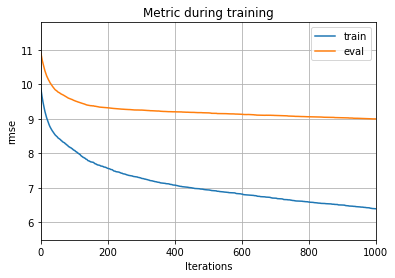

Plot feature importances...


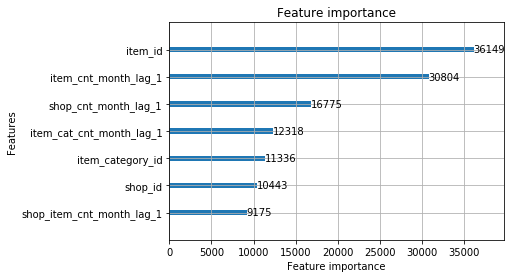

In [12]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig("lgb_plot_metric_"+saveName+".pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
if(saveplots):plt.savefig("lgb_plot_importance_"+saveName+".pdf")
plt.show()

In [13]:
pred_lgb = model.predict(x_train)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Training R-squared for LightGBM is 0.587245


In [14]:
pred_lgb = model.predict(x_val)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Validation R-squared for LightGBM is 0.326106


# Predict with test data

In [15]:
pred_submit = model.predict(x_test)
pred_submit.size

214200

# Validation with yearly trend

total sales count from constant_0p38 prediction: 81396.00000000001
total sales count from contant 0.5 prediction: 107100.0


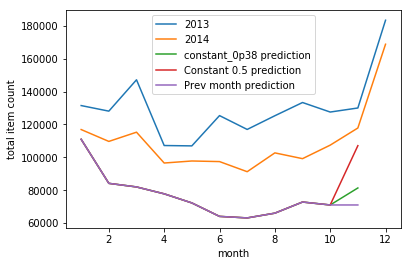

In [42]:
#import sys
#WorkDir = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/'
#sys.path.insert(0, WorkDir)
from utility.utility import plotYearly

y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
y_test['item_cnt_month'] = 0.38
saveName='constant_0p38'
saveplots=True

total_item_cnt_2013 = sales_train_2013.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = sales_val_2014.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = sales_test_2015.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

plotYearly(yearlySales,y_test,saveName,saveplots)

# Prepare submission file

In [45]:
test_sorted = test.sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName='Oct8-2018_3'
if submitName=='': 
    submitName=saveName
submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 0.38
submit[submit["ID"]==22987] =  0.38
